In [1]:
import os
import numpy as np
from pathlib import Path
from typing import Optional
from multiprocessing import Pool
import time
import random

In [2]:
# ========= constants =========
SAMPLE_RATE       = 25_000_000          # 25 Msps
BYTES_PER_SAMPLE  = 4                   # int16 I + int16 Q
FFT_SIZE          = 1024
FFT_HOP           = 512
LOWPASS_BW        = 5_000_000           # downsample to 5 MHz bandwidth
CLIP_RANGE_DB     = 80                  # dynamic range (80 dB)

In [3]:
# ========= read IQ =========
def read_texbat(path: str,
                start_sec: float = 0,
                duration_sec: Optional[float] = None,
                mmap: bool = False) -> np.ndarray:
    path       = Path(path)
    start_samp = int(start_sec * SAMPLE_RATE)
    byte_off   = start_samp * BYTES_PER_SAMPLE

    if duration_sec is None:
        count = -1                       # read to EOF
    else:
        n_samp = int(duration_sec * SAMPLE_RATE)
        count  = n_samp * 2              # I and Q

    if mmap:
        data = np.memmap(path, dtype='<i2', mode='r',
                         offset=byte_off, shape=(count if count>0 else None))
    else:
        with path.open('rb') as f:
            f.seek(byte_off)
            data = np.fromfile(f, dtype='<i2', count=count)

    # normalize to [-1, 1] to prevent dB calculation overflow
    iq = (data[0::2] + 1j * data[1::2]).astype(np.complex64) / 32768.0
    return iq


# ========= simple 2D average pooling =========
def pool_spec(spec: np.ndarray,
              pool_h: int = 4,
              pool_w: int = 128) -> np.ndarray:
    """average pooling to smaller resolution. default: 10s window, 50k frames -> ~400 columns"""
    h = spec.shape[0] - (spec.shape[0] % pool_h)
    w = spec.shape[1] - (spec.shape[1] % pool_w)
    spec = spec[:h, :w]
    spec = spec.reshape(h // pool_h, pool_h, w).mean(1)
    spec = spec.reshape(spec.shape[0], w // pool_w, pool_w).mean(2)
    return spec


# ========= main function: bin -> time-frequency image =========
def dump_images(bin_path, out_dir, win_sec=10, hop_sec=2):
    """process single bin file"""
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    print(f"start processing: {bin_path}")
    start_time = time.time()

    total_sec = Path(bin_path).stat().st_size / (BYTES_PER_SAMPLE * SAMPLE_RATE)
    start, idx = 0.0, 0
    while start + win_sec <= total_sec:
        iq = read_texbat(bin_path, start_sec=start, duration_sec=win_sec)

        # downsample to 5 Msps
        iq = signal.decimate(iq, 5)
        fs = SAMPLE_RATE // 5

        f, t, Zxx = signal.stft(iq, fs=fs,
                                window='hann',
                                nperseg=FFT_SIZE,
                                noverlap=FFT_HOP,
                                return_onesided=False,
                                boundary=None)


        # only take ±2 MHz
        band = np.where((f >= -2e6) & (f <= 2e6))[0]
        spec = 20 * np.log10(np.abs(Zxx[band]) + 1e-12)   # add 1e-12 to prevent log(0)

        # automatic dynamic range: take 99th percentile as vmax, then subtract 80 dB
        vmax = np.percentile(spec, 99)
        vmin = vmax - CLIP_RANGE_DB
        spec = np.clip(spec, vmin, vmax)
        spec = (spec - vmin) / (vmax - vmin)              # map to [0,1]

        # after pooling, interpolate to 224×224, convenient for MobileNet
        spec = pool_spec(spec, pool_h=4, pool_w=128)
        spec = signal.resample(spec, 224, axis=0)         # frequency dimension
        spec = signal.resample(spec, 224, axis=1)         # time dimension

        plt.imsave(f'{out_dir}/{idx:06d}.png', spec, cmap='viridis')
        start += hop_sec
        idx   += 1
    elapsed_time = time.time() - start_time
    print(f"completed processing: {bin_path}, time: {elapsed_time:.2f}s, total {idx} images")

In [4]:
# ========= multiprocess processing =========
def process_single_file(args):
    """wrapper function, for multiprocessing"""
    bin_path, out_dir, win_sec, hop_sec = args
    dump_images(bin_path, out_dir, win_sec, hop_sec)

def dump_images_multiprocess(bin_files, base_out_dir, win_sec=10, hop_sec=2, n_processes=6):
    """multiprocess processing multiple bin files
    
    Parameters
    ----------
    bin_files : list
        bin file path list
    base_out_dir : str
        output base directory
    win_sec : float
        window time length
    hop_sec : float
        hop time
    n_processes : int
        number of processes
    """
    # prepare parameter list
    tasks = []
    for i, bin_path in enumerate(bin_files):
        out_dir = f"{base_out_dir}/{Path(bin_path).stem}"
        tasks.append((bin_path, out_dir, win_sec, hop_sec))
    
    print(f"start multiprocessing {len(bin_files)} files, using {n_processes} processes")
    
    # create process pool and execute
    with Pool(processes=n_processes) as pool:
        pool.map(process_single_file, tasks)
    
    print("all files processed!")

In [5]:
# ============ step 1: data processing ============
# if data is not processed, uncomment the following code
# if __name__ == '__main__':
#     print("start processing raw data...")
#     bin_files = [
#         'H:/ds1.bin',
#         'H:/ds2.bin', 
#         'H:/ds3.bin',
#         'H:/ds4.bin',
#         'H:/ds7.bin',
#         'H:/cleanDynamic.bin'
#     ]
    
#     dump_images_multiprocess(
#         bin_files=bin_files,
#         base_out_dir='H:/processed_data',
#         win_sec=10,
#         hop_sec=2,
#         n_processes=2
#     )
#     print("data processing completed!")

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [7]:
# set random seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [8]:
# ========= dataset class =========
class SpoofingDataset(Dataset):
    """signal spoofing detection dataset"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # load image (assume .npy or .png file)
        if self.image_paths[idx].endswith('.png'):
            import cv2
            image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
            image = image.astype(np.float32) / 255.0
        else:
            image = np.load(self.image_paths[idx]).astype(np.float32)
        
        # convert to tensor
        image = torch.from_numpy(image).unsqueeze(0)  # add channel dimension
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.labels[idx]


def prepare_dataset(data_dir, test_size=0.2, val_size=0.1):
    """
    prepare training, validation and test datasets
    
    note: the first 100 seconds of each spoof signal file are real signals
    - 100 seconds / hop_sec(2 seconds) = first 50 images are real signals
    - from the 51st image onwards are spoof signals
    
    Args:
        data_dir: root directory of processed data (contains subfolders of different categories)
        test_size: test set ratio
        val_size: validation set ratio
    
    Returns:
        train_loader, val_loader, test_loader
    """
    # collect all image paths and labels
    image_paths = []
    labels = []
    
    # data folder classification
    real_signal_dirs = ['cleanDynamic']  # completely real signals
    mixed_signal_dirs = ['ds1', 'ds2', 'ds3', 'ds4', 'ds7']  # first 100 seconds real, then spoof
    
    # number of images corresponding to the first 100 seconds (10 seconds per image, hop_sec=2, so first 50 images are real signals)
    REAL_SIGNAL_THRESHOLD = 50  # first 50 images
    
    # load pure real signal folders
    real_count = 0
    for dirname in real_signal_dirs:
        dir_path = os.path.join(data_dir, dirname)
        if os.path.exists(dir_path):
            png_files = sorted(glob.glob(os.path.join(dir_path, '*.png')))
            image_paths.extend(png_files)
            labels.extend([0] * len(png_files))  # 0 represents real signals
            real_count += len(png_files)
            print(f"load pure real signal: {dirname}, total {len(png_files)} samples")
    
    # load mixed signal folders (first 50 real, then spoof)
    spoof_count = 0
    for dirname in mixed_signal_dirs:
        dir_path = os.path.join(data_dir, dirname)
        if os.path.exists(dir_path):
            png_files = sorted(glob.glob(os.path.join(dir_path, '*.png')))
            
            real_in_spoof = 0
            spoof_in_spoof = 0
            
            for png_file in png_files:
                # extract image index from filename (assume format is 000000.png, 000001.png, ...)
                filename = os.path.basename(png_file)
                try:
                    img_index = int(filename.split('.')[0])
                    
                    image_paths.append(png_file)
                    
                    if img_index < REAL_SIGNAL_THRESHOLD:
                        # first 50 images are real signals
                        labels.append(0)
                        real_in_spoof += 1
                    else:
                        # from the 51st image onwards are spoof signals
                        labels.append(1)
                        spoof_in_spoof += 1
                        
                except ValueError:
                    # if filename format is not as expected, skip
                    print(f"warning: skip file with abnormal filename: {png_file}")
                    continue
            
            real_count += real_in_spoof
            spoof_count += spoof_in_spoof
            print(f"load mixed signal: {dirname}, real signals: {real_in_spoof} samples, spoof signals: {spoof_in_spoof} samples")
    
    print(f"\ndata label statistics:")
    print(f"total {len(image_paths)} samples")
    print(f"real signals: {real_count} samples ({labels.count(0)} samples)")
    print(f"spoof signals: {spoof_count} samples ({labels.count(1)} samples)")
    
    # check if label statistics is correct
    if labels.count(0) != real_count or labels.count(1) != spoof_count:
        print("warning: label statistics is inconsistent, please check data label logic")
    
    if len(image_paths) == 0:
        raise ValueError("no image files found, please check data directory path")
    
    # data splitting
    # first split training+validation and test
    X_temp, X_test, y_temp, y_test = train_test_split(
        image_paths, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    # then split validation from training+validation
    val_size_adj = val_size / (1 - test_size)  # adjust validation set ratio
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adj, random_state=42, stratify=y_temp
    )
    
    print(f"\ndata set splitting:")
    print(f"training set: {len(X_train)} samples")
    print(f"validation set: {len(X_val)} samples")
    print(f"test set: {len(X_test)} samples")
    
    # create dataset and loaders
    train_dataset = SpoofingDataset(X_train, y_train)
    val_dataset = SpoofingDataset(X_val, y_val)
    test_dataset = SpoofingDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    return train_loader, val_loader, test_loader

In [9]:
# ============ step 2: prepare dataset ============
data_dir = 'G:/processed_data'  # processed data directory
print("prepare dataset...")
train_loader, val_loader, test_loader = prepare_dataset(data_dir)

prepare dataset...
load pure real signal: cleanDynamic, total 217 samples
load mixed signal: ds1, real signals: 50 samples, spoof signals: 176 samples
load mixed signal: ds2, real signals: 50 samples, spoof signals: 174 samples
load mixed signal: ds3, real signals: 50 samples, spoof signals: 174 samples
load mixed signal: ds4, real signals: 50 samples, spoof signals: 175 samples
load mixed signal: ds7, real signals: 50 samples, spoof signals: 181 samples

data label statistics:
total 1347 samples
real signals: 467 samples (467 samples)
spoof signals: 880 samples (880 samples)

data set splitting:
training set: 942 samples
validation set: 135 samples
test set: 270 samples


In [10]:
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm

In [11]:
# ========= model definition =========
class InvertedResidual(nn.Module):
    """inverted residual block"""
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw (pointwise convolution expansion)
            layers.extend([
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
            ])
        layers.extend([
            # dw (depthwise convolution)
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            # pw-linear (pointwise convolution projection)
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    """
    MobileNetV2 architecture, for signal spoofing detection
    input: 224x224x1 time-frequency image
    output: 2-class probabilities (real vs spoof)
    
    support freezing part of the layers to implement transfer learning
    """
    def __init__(self, num_classes=2, width_mult=1.0, dropout=0.2, freeze_layers=None):
        super(MobileNetV2, self).__init__()
        
        # set number of channels
        input_channel = 32
        last_channel = 1280
        
        # inverted residual block configuration: [expand_ratio, output_channel, num_blocks, stride]
        inverted_residual_setting = [
            [1, 16, 1, 1],   # t, c, n, s
            [6, 24, 2, 2],   # 112x112
            [6, 32, 3, 2],   # 56x56
            [6, 64, 4, 2],   # 28x28
            [6, 96, 3, 1],   # 28x28
            [6, 160, 3, 2],  # 14x14
            [6, 320, 1, 1],  # 14x14
        ]

        # adjust number of channels
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * max(1.0, width_mult))
        
        # first convolution layer (224x224x1 -> 112x112x32)
        features = [
            nn.Conv2d(1, input_channel, 3, stride=2, padding=1, bias=False),  # input is single-channel time-frequency image
            nn.BatchNorm2d(input_channel),
            nn.ReLU6(inplace=True)
        ]
        
        # build inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        
        # last convolution layer
        features.append(
            nn.Conv2d(input_channel, self.last_channel, 1, 1, 0, bias=False)
        )
        features.append(nn.BatchNorm2d(self.last_channel))
        features.append(nn.ReLU6(inplace=True))
        
        # feature extractor
        self.features = nn.Sequential(*features)
        
        # classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.last_channel, num_classes),
        )
        
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
        
        # apply layer freezing strategy
        if freeze_layers is not None:
            self.apply_freeze_strategy(freeze_layers)

    def forward(self, x):
        """
        forward propagation
        Args:
            x: input tensor (batch_size, 1, 224, 224)
        Returns:
            logits: classification output (batch_size, num_classes)
        """
        # feature extraction
        x = self.features(x)
        # global average pooling
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        # flatten
        x = torch.flatten(x, 1)
        # classification
        x = self.classifier(x)
        return x
    
    def apply_freeze_strategy(self, freeze_strategy):
        """
        apply freezing strategy
        
        Args:
            freeze_strategy: freezing strategy, support:
                - 'features': freeze all feature extraction layers, only train classifier
                - 'early_features': freeze first 50% of feature layers
                - 'backbone': freeze first 70% of feature layers  
                - int: freeze first N feature layers
                - list: freeze specified layers [0, 1, 2, ...]
        """
        print(f"apply freezing strategy: {freeze_strategy}")
        
        if freeze_strategy == 'features':
            # freeze all feature extraction layers
            self._freeze_module(self.features)
            
        elif freeze_strategy == 'early_features':
            # freeze first 50% of feature layers
            total_layers = len(self.features)
            freeze_count = total_layers // 2
            self._freeze_layers_by_count(freeze_count)
            
        elif freeze_strategy == 'backbone':
            # freeze first 70% of feature layers
            total_layers = len(self.features)
            freeze_count = int(total_layers * 0.7)
            self._freeze_layers_by_count(freeze_count)
            
        elif isinstance(freeze_strategy, int):
            # freeze
            self._freeze_layers_by_count(freeze_strategy)
            
        elif isinstance(freeze_strategy, list):
            # freeze specified layers
            self._freeze_layers_by_indices(freeze_strategy)
            
        # print trainable parameters statistics
        self._print_trainable_params()
    
    def _freeze_module(self, module):
        """freeze entire module"""
        for param in module.parameters():
            param.requires_grad = False
    
    def _freeze_layers_by_count(self, freeze_count):
        """freeze first N layers"""
        for i, layer in enumerate(self.features):
            if i < freeze_count:
                self._freeze_module(layer)
    
    def _freeze_layers_by_indices(self, indices):
        """freeze specified layers"""
        for i in indices:
            if i < len(self.features):
                self._freeze_module(self.features[i])
    
    def _print_trainable_params(self):
        """print trainable parameters statistics"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        frozen_params = total_params - trainable_params
        
        print(f"📊 parameters statistics:")
        print(f"    total parameters: {total_params:,}")
        print(f"    trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")
        print(f"    frozen parameters: {frozen_params:,} ({100*frozen_params/total_params:.1f}%)")
    
    def unfreeze_all(self):
        """unfreeze all parameters"""
        for param in self.parameters():
            param.requires_grad = True
        self._print_trainable_params()
    
    def freeze_features_gradually(self, epoch, total_epochs, strategy='linear'):
        """
        progressive unfreezing strategy (optional for dynamic adjustment during training)
        
        Args:
            epoch: current training epoch
            total_epochs: total training epochs
            strategy: unfreezing strategy ('linear', 'exponential')
        """
        if strategy == 'linear':
            # linear unfreezing: gradually unfreeze more layers as training progresses
            unfreeze_ratio = epoch / total_epochs
            total_layers = len(self.features)
            unfreeze_count = int(total_layers * unfreeze_ratio)
            
            # freeze all, then unfreeze first N layers
            self._freeze_module(self.features)
            for i in range(unfreeze_count):
                for param in self.features[i].parameters():
                    param.requires_grad = True

In [12]:
# ============ training strategy selection ============
# 1. fine-tuning - freeze backbone (recommended):
#    - freeze_strategy = 'backbone'
#    - lr = 0.00007, epochs = 20-30  
   
# 2. progressive fine-tuning - freeze early features:
#    - freeze_strategy = 'early_features'
#    - lr = 0.0001, epochs = 25-40
   
# 3. custom freeze:
#    - freeze_strategy = 10 (freeze first 10 layers)
#    - freeze_strategy = [0,1,2,3] (freeze specified layers)

In [13]:
# ============ step 3: initialize model ============
freeze_strategy = 'backbone'

model = MobileNetV2(
    num_classes=2, 
    width_mult=1.0, 
    dropout=0.2,
    freeze_layers=freeze_strategy
)

print(f"use freeze strategy: {freeze_strategy}")
print(f"learning rate: {0.00007} (suitable for frozen layer training)")
print(f"training epochs: {20} (suitable for fine-tuning)")

apply freezing strategy: backbone
📊 parameters statistics:
    total parameters: 2,225,858
    trainable parameters: 1,683,906 (75.7%)
    frozen parameters: 541,952 (24.3%)
use freeze strategy: backbone
learning rate: 7e-05 (suitable for frozen layer training)
training epochs: 20 (suitable for fine-tuning)


In [14]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=0.00007, device='cuda'):
    """
    train model
    
    Args:
        model: MobileNetV2 model
        train_loader: training data loader
        val_loader: validation data loader
        num_epochs: training epochs
        lr: learning rate
        device: device ('cuda' or 'cpu')
    
    Returns:
        trained_model, train_losses, val_losses, val_accuracies
    """
    model.to(device)
    
    # define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    
    # record training process
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    
    print(f"\nstart training, using device: {device}")
    print(f"training epochs: {num_epochs}, learning rate: {lr}")
    
    for epoch in range(num_epochs):
        # ============ training phase ============
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [training]')
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
            
            # update progress bar
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        
        # ============ validation phase ============
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [validation]')
            for data, target in val_pbar:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
                
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*val_correct/val_total:.2f}%'
                })
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        
        # record history
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        
        # learning rate scheduling
        scheduler.step(val_acc)
        
        # save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"★ save best model, validation accuracy: {val_acc:.2f}%")
        
        # print epoch results
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  training - Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}%')
        print(f'  validation - Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%')
        print(f'  learning rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 50)
    
    return model, train_losses, val_losses, val_accuracies


def test_model(model, test_loader, device='cuda'):
    """
    test model performance
    
    Args:
        model: trained model
        test_loader: test data loader
        device: device
    
    Returns:
        accuracy, predictions, true_labels
    """
    model.to(device)
    model.eval()
    
    all_predictions = []
    all_labels = []
    
    print("\nstart testing model...")
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='testing progress')
        for data, target in test_pbar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    # calculate accuracy
    accuracy = accuracy_score(all_labels, all_predictions)
    
    # generate detailed report
    print(f"\n{'='*50}")
    print(f"testing results")
    print(f"{'='*50}")
    print(f"testing accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print(f"\nconfusion matrix:")
    print(f"{'':>12} {'real signal':>8} {'spoof signal':>8}")
    print(f"{'real signal':>12} {cm[0,0]:>8} {cm[0,1]:>8}")
    print(f"{'spoof signal':>12} {cm[1,0]:>8} {cm[1,1]:>8}")
    
    # classification report
    print(f"\ndetailed classification report:")
    target_names = ['real signal', 'spoof signal']
    print(classification_report(all_labels, all_predictions, target_names=target_names))
    
    return accuracy, all_predictions, all_labels


def plot_training_history(train_losses, val_losses, val_accuracies):
    """plot training history"""
    # Create the figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curve
    ax1.plot(train_losses, label='Training loss', color='blue')
    ax1.plot(val_losses, label='Validation loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy curve
    ax2.plot(val_accuracies, label='Validation Accuracy', color='green')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Save the plot to a file
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    
    # Display the plot inline in Jupyter notebook
    plt.show()


In [15]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cuda


In [16]:
# ============ step 4: train model ============
print("start training...")
model, train_losses, val_losses, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=20,
    lr=0.00007,
    device=device
)

start training...

start training, using device: cuda
training epochs: 20, learning rate: 7e-05


Epoch 1/20 [validation]: 100%|███████████████| 5/5 [00:00<00:00, 12.65it/s, Loss=0.8760, Acc=65.19%]


★ save best model, validation accuracy: 65.19%
Epoch 1/20:
  training - Loss: 0.6131, Acc: 64.23%
  validation - Loss: 0.6931, Acc: 65.19%
  learning rate: 0.000070
--------------------------------------------------


Epoch 2/20 [validation]: 100%|███████████████| 5/5 [00:00<00:00, 16.51it/s, Loss=1.3796, Acc=65.19%]


Epoch 2/20:
  training - Loss: 0.3917, Acc: 82.17%
  validation - Loss: 0.9551, Acc: 65.19%
  learning rate: 0.000070
--------------------------------------------------


Epoch 3/20 [validation]: 100%|███████████████| 5/5 [00:00<00:00, 17.66it/s, Loss=0.6459, Acc=77.78%]


★ save best model, validation accuracy: 77.78%
Epoch 3/20:
  training - Loss: 0.2673, Acc: 89.81%
  validation - Loss: 0.4304, Acc: 77.78%
  learning rate: 0.000070
--------------------------------------------------


Epoch 4/20 [validation]: 100%|███████████████| 5/5 [00:00<00:00, 16.14it/s, Loss=0.3241, Acc=89.63%]


★ save best model, validation accuracy: 89.63%
Epoch 4/20:
  training - Loss: 0.2239, Acc: 91.40%
  validation - Loss: 0.2565, Acc: 89.63%
  learning rate: 0.000070
--------------------------------------------------


Epoch 5/20 [validation]: 100%|███████████████| 5/5 [00:00<00:00, 14.59it/s, Loss=0.4467, Acc=90.37%]


★ save best model, validation accuracy: 90.37%
Epoch 5/20:
  training - Loss: 0.1807, Acc: 93.63%
  validation - Loss: 0.2551, Acc: 90.37%
  learning rate: 0.000070
--------------------------------------------------


Epoch 6/20 [validation]: 100%|███████████████| 5/5 [00:00<00:00, 14.49it/s, Loss=0.2697, Acc=90.37%]


Epoch 6/20:
  training - Loss: 0.1597, Acc: 94.37%
  validation - Loss: 0.2418, Acc: 90.37%
  learning rate: 0.000070
--------------------------------------------------


Epoch 7/20 [validation]: 100%|███████████████| 5/5 [00:00<00:00, 16.46it/s, Loss=0.2588, Acc=90.37%]


Epoch 7/20:
  training - Loss: 0.1434, Acc: 94.80%
  validation - Loss: 0.2491, Acc: 90.37%
  learning rate: 0.000070
--------------------------------------------------


Epoch 8/20 [validation]: 100%|███████████████| 5/5 [00:00<00:00, 16.86it/s, Loss=0.4639, Acc=90.37%]


Epoch 8/20:
  training - Loss: 0.1066, Acc: 96.60%
  validation - Loss: 0.2352, Acc: 90.37%
  learning rate: 0.000070
--------------------------------------------------


Epoch 9/20 [validation]: 100%|███████████████| 5/5 [00:00<00:00, 19.20it/s, Loss=0.7042, Acc=89.63%]


Epoch 9/20:
  training - Loss: 0.1066, Acc: 96.60%
  validation - Loss: 0.3030, Acc: 89.63%
  learning rate: 0.000070
--------------------------------------------------


Epoch 10/20 [validation]: 100%|██████████████| 5/5 [00:00<00:00, 16.99it/s, Loss=0.2165, Acc=94.07%]


★ save best model, validation accuracy: 94.07%
Epoch 10/20:
  training - Loss: 0.0645, Acc: 98.30%
  validation - Loss: 0.1880, Acc: 94.07%
  learning rate: 0.000070
--------------------------------------------------


Epoch 11/20 [validation]: 100%|██████████████| 5/5 [00:00<00:00, 14.51it/s, Loss=0.1527, Acc=91.85%]


Epoch 11/20:
  training - Loss: 0.0744, Acc: 97.66%
  validation - Loss: 0.2212, Acc: 91.85%
  learning rate: 0.000070
--------------------------------------------------


Epoch 12/20 [validation]: 100%|██████████████| 5/5 [00:00<00:00, 15.61it/s, Loss=0.2186, Acc=92.59%]


Epoch 12/20:
  training - Loss: 0.0542, Acc: 98.41%
  validation - Loss: 0.2251, Acc: 92.59%
  learning rate: 0.000070
--------------------------------------------------


Epoch 13/20 [validation]: 100%|██████████████| 5/5 [00:00<00:00, 17.33it/s, Loss=0.2242, Acc=94.07%]


Epoch 13/20:
  training - Loss: 0.0580, Acc: 98.20%
  validation - Loss: 0.1983, Acc: 94.07%
  learning rate: 0.000070
--------------------------------------------------


Epoch 14/20 [validation]: 100%|██████████████| 5/5 [00:00<00:00, 16.58it/s, Loss=0.1339, Acc=92.59%]


Epoch 14/20:
  training - Loss: 0.0459, Acc: 98.73%
  validation - Loss: 0.2019, Acc: 92.59%
  learning rate: 0.000070
--------------------------------------------------


Epoch 15/20 [validation]: 100%|██████████████| 5/5 [00:00<00:00, 14.61it/s, Loss=0.2179, Acc=94.07%]


Epoch 15/20:
  training - Loss: 0.0437, Acc: 99.15%
  validation - Loss: 0.1984, Acc: 94.07%
  learning rate: 0.000070
--------------------------------------------------


Epoch 16/20 [validation]: 100%|██████████████| 5/5 [00:00<00:00, 17.03it/s, Loss=0.5176, Acc=91.11%]


Epoch 16/20:
  training - Loss: 0.0356, Acc: 99.26%
  validation - Loss: 0.2649, Acc: 91.11%
  learning rate: 0.000035
--------------------------------------------------


Epoch 17/20 [validation]: 100%|██████████████| 5/5 [00:00<00:00, 16.36it/s, Loss=0.1673, Acc=93.33%]


Epoch 17/20:
  training - Loss: 0.0278, Acc: 99.47%
  validation - Loss: 0.2072, Acc: 93.33%
  learning rate: 0.000035
--------------------------------------------------


Epoch 18/20 [validation]: 100%|██████████████| 5/5 [00:00<00:00, 15.60it/s, Loss=0.2603, Acc=90.37%]


Epoch 18/20:
  training - Loss: 0.0264, Acc: 99.47%
  validation - Loss: 0.2512, Acc: 90.37%
  learning rate: 0.000035
--------------------------------------------------


Epoch 19/20 [validation]: 100%|██████████████| 5/5 [00:00<00:00, 15.57it/s, Loss=0.3153, Acc=92.59%]


Epoch 19/20:
  training - Loss: 0.0283, Acc: 99.26%
  validation - Loss: 0.1987, Acc: 92.59%
  learning rate: 0.000035
--------------------------------------------------


Epoch 20/20 [validation]: 100%|██████████████| 5/5 [00:00<00:00, 15.52it/s, Loss=0.1964, Acc=93.33%]


Epoch 20/20:
  training - Loss: 0.0237, Acc: 99.36%
  validation - Loss: 0.2013, Acc: 93.33%
  learning rate: 0.000035
--------------------------------------------------


In [17]:
# ============ step 5: test model ============
# load best model
model.load_state_dict(torch.load('best_model.pth'))
print("load best model for testing...")

accuracy, predictions, true_labels = test_model(model, test_loader, device)

load best model for testing...

start testing model...


testing progress: 100%|███████████████████████████████████████████████| 9/9 [00:00<00:00, 14.68it/s]


testing results
testing accuracy: 0.9593 (95.93%)

confusion matrix:
             real signal spoof signal
 real signal       92        2
spoof signal        9      167

detailed classification report:
              precision    recall  f1-score   support

 real signal       0.91      0.98      0.94        94
spoof signal       0.99      0.95      0.97       176

    accuracy                           0.96       270
   macro avg       0.95      0.96      0.96       270
weighted avg       0.96      0.96      0.96       270



generate training history graph...


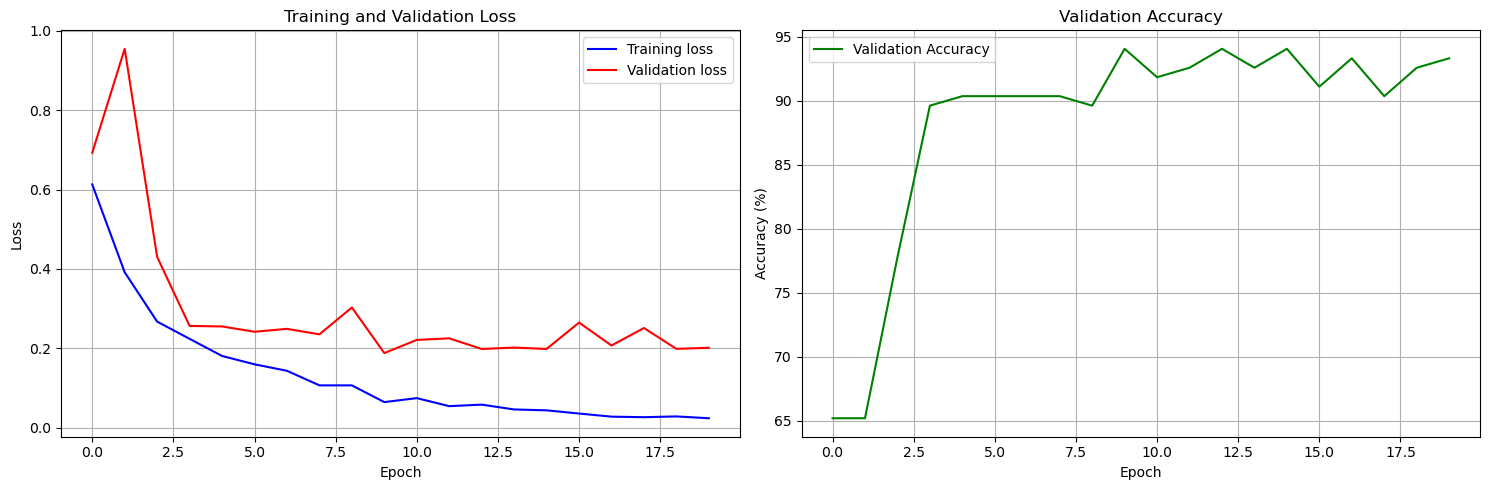

In [18]:
# ============ step 6: visualize results ============
print("generate training history graph...")
plot_training_history(train_losses, val_losses, val_accuracies)

In [19]:
# ============ summary ============
print(f"\n{'='*60}")
print(f"training completed!")
print(f"{'='*60}")
print(f"final test accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"model saved as: best_model.pth")
print(f"training history graph saved as: training_history.png")


training completed!
final test accuracy: 0.9593 (95.93%)
model saved as: best_model.pth
training history graph saved as: training_history.png
